In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

sns.set()

In [2]:
from loader import *
from neural_network import *
from plot import *
from train import *
from loss import *

# LOAD FILES AND PREPARE TRAIN AND TEST SET

In [3]:
# LOAD CSV FILES
insee_dataset = pd.read_csv('../data/data_INSEE_clean.csv', sep=';', dtype = {'code': str})
first_round_result = pd.read_csv("../data/clean_f_round_elect_results.csv", sep = ";", \
                                     dtype = {'Code Insee': str}).drop(columns=["Inscrits", "Nuls", "Votants"])

dataset = insee_dataset.merge(first_round_result, how='inner', left_on='code', right_on='Code Insee') \
                             .drop(columns=["Code Insee"])


candidates_list = ['JADOT', 'DUPONT-AIGNAN', 'LASSALLE', 'ARTHAUD', 'POUTOU', \
                   'ROUSSEL', 'MACRON', 'MÉLENCHON', 'ZEMMOUR', 'PECRESSE', 'LE PEN', 'HIDALGO']

nb_candidates = len(candidates_list)

In [4]:
# DIFFERENT SETS OF FEATURES 
sparse_features = ['density_pop', 'Indice_vieillissement', 'ratio_etude_sup','mean_familiy_size',\
                   'ratio_etude_sup', 'hlm', 'res_second', 'ta_homme', 'part_agri_y', 'part_cadre']

all_features = list(set(insee_dataset.columns) - set(["code", "commune", "pop", "type_agglo"]))

features_wo_equipmements = list(set(all_features)-set(['hypermarché', 'pôle emploi','banques', 'poste', 'epicerie', \
                'boulangerie', 'boucherie', 'maternelle', 'élémentaire', 'collège', 'urgences', \
                'lycee', 'dentiste', 'medecin','infirmier', 'creche', 'kine', 'pharmacie', 'epahd']))

In [5]:
# CHOOSE HERE THE SET FEATURES YOU WANT TO KEEP
features_to_keep = all_features
nb_features = len(features_to_keep)

print("number of initial features", nb_features)

# Variables
batch_size = 36 
min_habs = 500 
test_size = 0.5 
apply_PCA, n_components = False, 20 
if apply_PCA : nb_features = n_components
    
    

number of initial features 67


In [6]:
x_train, x_test, y_train, y_test, train_loader, commune_index_train, commune_index_test = \
    load_data(dataset, features_to_keep, batch_size, min_habs, test_size, \
              apply_PCA=apply_PCA, n_components_PCA=n_components)

df_y_train = pd.DataFrame(y_train, columns=candidates_list)
df_y_test = pd.DataFrame(y_test, columns=candidates_list)

In [7]:
print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)


x_train shape (7072, 67)
y_train shape (7072, 12)
x_test shape (7073, 67)
y_test shape (7073, 12)


# COMPARE NEURAL NETWORK WITHOUT AND WITHOUT SOFTMAX

In [8]:
model_no_softmax =  NN2Layers_no_softmax(nb_features, 200, nb_candidates)
model_with_softmax = NN2Layers_with_softmax(nb_features, 200, nb_candidates)
model_1Layer = NN1Layer(nb_features, nb_candidates)

In [9]:
optimizer_no_softmax = torch.optim.Adam(model_no_softmax.parameters())
optimizer_with_softmax = torch.optim.Adam(model_with_softmax.parameters())
optimizer_1Layer = torch.optim.Adam(model_1Layer.parameters())

In [10]:
train_neurals_networks(40, train_loader, \
                       [cross_entropy_loss, cross_entropy_loss, cross_entropy_loss], \
                       [model_no_softmax, model_with_softmax, model_1Layer], \
                       [optimizer_no_softmax, optimizer_with_softmax, optimizer_1Layer], print_epochs=10)

epoch n° 0
  model n° 0 - loss : 2.173139469272594
  model n° 1 - loss : 2.064914645277304
  model n° 2 - loss : 2.532476357397089
----
epoch n° 10
  model n° 0 - loss : 2.0151888107890406
  model n° 1 - loss : 2.0082134807170346
  model n° 2 - loss : 2.0376132569337253
----
epoch n° 20
  model n° 0 - loss : 2.00881179214129
  model n° 1 - loss : 2.0045335159689035
  model n° 2 - loss : 2.0161178184644823
----
epoch n° 30
  model n° 0 - loss : 2.0063886146254952
  model n° 1 - loss : 2.0032678031679336
  model n° 2 - loss : 2.0138498623359022
----


In [11]:
list_of_pred_df = pred_model(x_train, x_test, [model_no_softmax, model_with_softmax, model_1Layer])

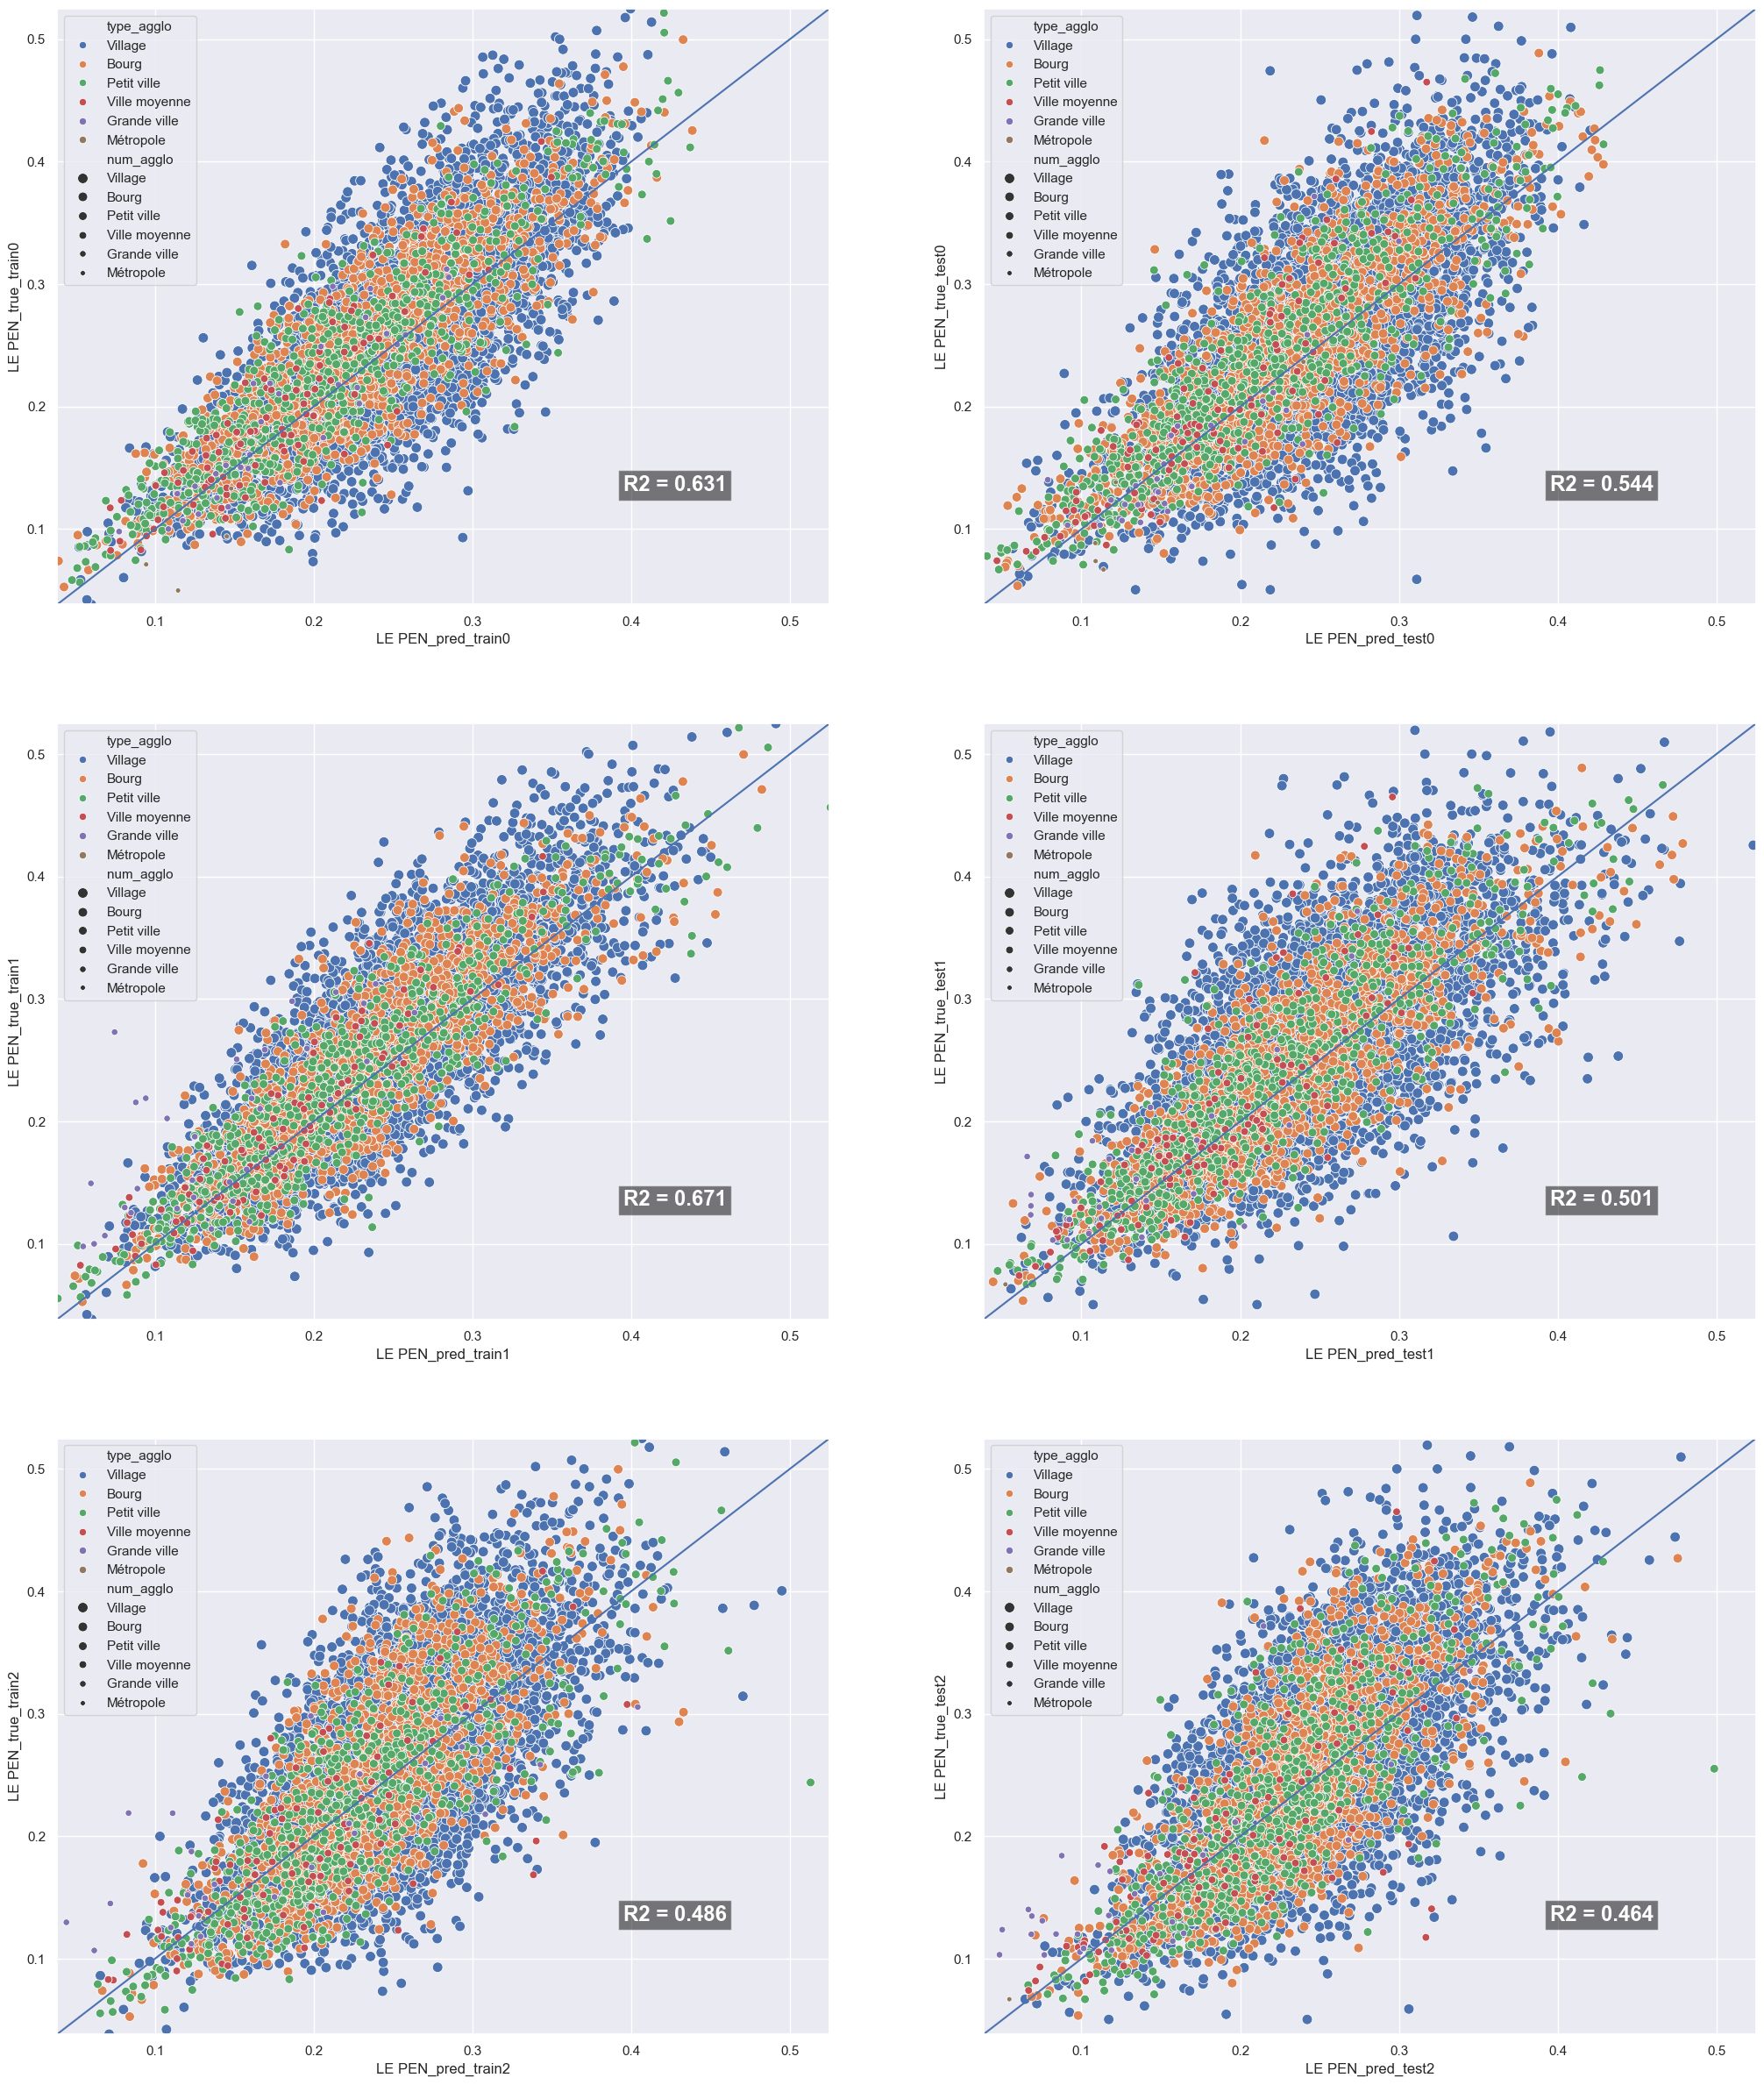

In [12]:
regression_plot(y_train, y_test, list_of_pred_df, "LE PEN", commune_index_train, commune_index_test)

In [13]:
compute_R2_df(list_of_pred_df[2][1],df_y_test)

R2 for JADOT  :  -0.03194931292895897
R2 for DUPONT-AIGNAN  :  0.21218036239244564
R2 for LASSALLE  :  0.20209157946675882
R2 for ARTHAUD  :  0.07945198680066512
R2 for POUTOU  :  0.018742257381398342
R2 for ROUSSEL  :  -0.028274094661152382
R2 for MACRON  :  0.4029624762946299
R2 for MÉLENCHON  :  0.18374384971733881
R2 for ZEMMOUR  :  0.3389118521649531
R2 for PECRESSE  :  0.12386864037207435
R2 for LE PEN  :  0.46364979282217234
R2 for HIDALGO  :  0.0404534070808682


[-0.03194931292895897,
 0.21218036239244564,
 0.20209157946675882,
 0.07945198680066512,
 0.018742257381398342,
 -0.028274094661152382,
 0.4029624762946299,
 0.18374384971733881,
 0.3389118521649531,
 0.12386864037207435,
 0.46364979282217234,
 0.0404534070808682]